# Import packages, set matplotlib params

In [ ]:
import sys
!conda install --yes --prefix {sys.prefix} iminuit

In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import gridspec
from iminuit import Minuit
from iminuit.cost import LeastSquares

%matplotlib inline
%matplotlib notebook

plt.rcParams['savefig.dpi'] = 200
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 20
plt.rcParams['lines.markersize'] = 4.0
plt.rcParams['lines.linewidth'] = 2.0

rng = default_rng()

In [17]:
# frequency = 'Daily'
# frequency = 'Weekly'
frequency = 'Monthly'

# Read `.xlsx` files into pandas Dataframe

In [18]:
if frequency == 'Daily':
    timecol = 'Trddt'
    try:
        df = pd.read_pickle(frequency + 'dataframeorigin.pkl')
    except:
        dfd0 = pd.read_excel('TRD_Dalyr.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
        dfd1 = pd.read_excel('TRD_Dalyr1.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
        dfd2 = pd.read_excel('TRD_Dalyr2.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])
        dfd3 = pd.read_excel('TRD_Dalyr3.xlsx', header=0, usecols=[0, 1, 3], skiprows=[1, 2], parse_dates=[1])

        df = pd.concat([dfd0, dfd1, dfd2, dfd3])
elif frequency == 'Weekly':
    timecol = 'Trdwnt'
    try:
        df = pd.read_pickle(frequency + 'dataframeorigin.pkl')
    except:
        dfw0 = pd.read_excel('TRD_Week.xlsx', header=0, usecols=[0, 1, 2], skiprows=[1, 2], parse_dates=[1])
        dfw1 = pd.read_excel('TRD_Week1.xlsx', header=0, usecols=[0, 1, 2], skiprows=[1, 2], parse_dates=[1])
        dfw2 = pd.read_excel('TRD_Week2.xlsx', header=0, usecols=[0, 1, 2], skiprows=[1, 2], parse_dates=[1])

        df = pd.concat([dfw0, dfw1, dfw2])
elif frequency == 'Monthly':
    timecol = 'Trdmnt'
    try:
        df = pd.read_pickle(frequency + 'dataframeorigin.pkl')
    except:
        df = pd.read_excel('TRD_Mnth.xlsx', header=0, usecols=[0, 1, 2], skiprows=[1, 2], parse_dates=[1])

df.to_pickle(frequency + 'dataframeorigin.pkl')
qlist = np.arange(0, 1, 0.05)
s = np.empty(len(qlist))
for i in tqdm(range(len(qlist))):
    nanaug = df.set_index([timecol, 'Stkcd']).unstack()
    # nannumt = nanaug.T.isna().sum()
    # nanaug = nanaug.T[nanaug.T.columns[nannumt < nannumt.quantile(qlist[i])]].T
    nannums = nanaug.isna().sum()
    s[i] = nanaug[nanaug.columns[nannums < nannums.quantile(qlist[i])]].dropna(axis='index', how='any').size
q = qlist[s.argmax()]
nanaug = df.set_index([timecol, 'Stkcd']).unstack()
# nannumt = nanaug.T.isna().sum()
# nanaug = nanaug.T[nanaug.T.columns[nannumt < nannumt.quantile(q)]].T
nannums = nanaug.isna().sum()
nanaug = nanaug[nanaug.columns[nannums < nannums.quantile(q)]].dropna(axis='index', how='any')
stocks = nanaug.columns.droplevel().values
df_valid = df[df['Stkcd'].isin(stocks)]
df_valid.to_pickle(frequency + 'dataframevalid.pkl')
df_valid.to_csv(frequency + 'dataframevalid.csv')
df_cov = df_valid.set_index([timecol, 'Stkcd']).unstack().dropna(axis='index', how='any').cov()
df_cov.to_pickle(frequency + 'dataframe.pkl')
df_cov.to_csv(frequency + 'dataframe.csv')
cov = df_cov.values 
assert ~np.any(np.isnan(cov))


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.76it/s]


<IPython.core.display.Javascript object>


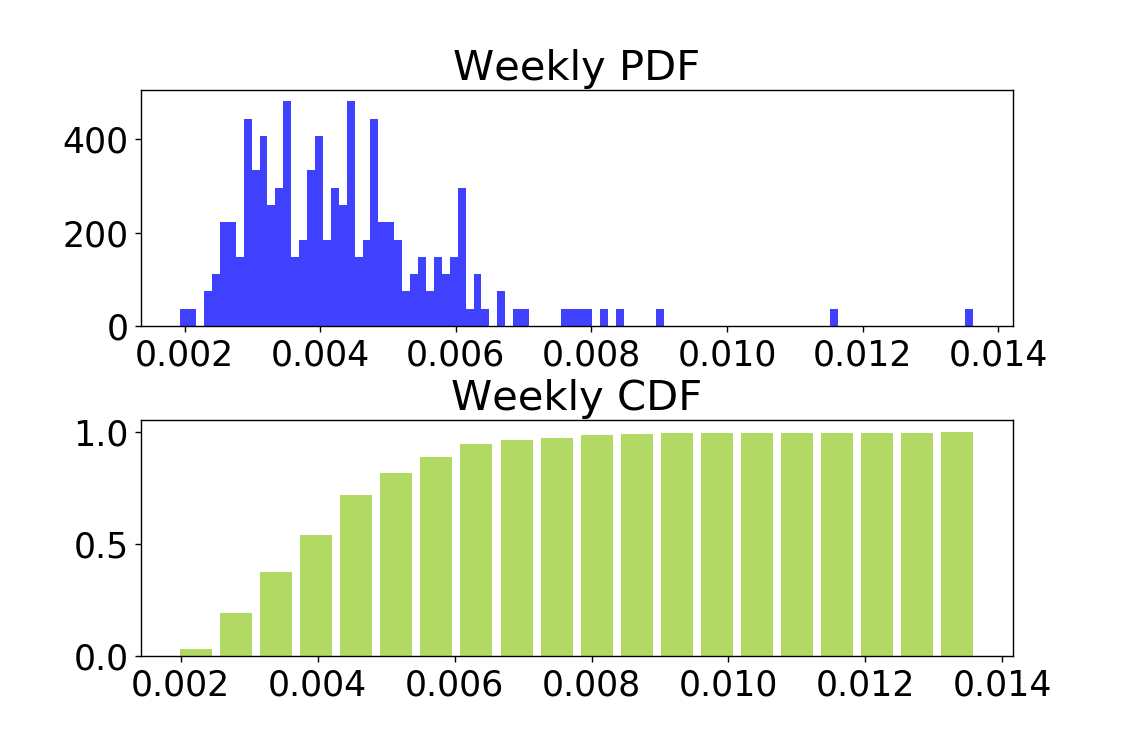

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


In [5]:
# 描述性统计
stockcov = np.diagonal(cov)
stockvar = pd.DataFrame(stockcov)
stockvar.to_csv(frequency + 'StockVar.csv')
stockvar.describe()

# 绘制频率直方图
fig,(ax0,ax1) = plt.subplots(nrows=2,figsize=(9,6)) 
ax0.hist(stockcov,100,normed=1,histtype='bar',facecolor='blue',alpha=0.75) 
ax0.set_title(frequency + ' PDF')  
ax1.hist(stockcov,20,normed=1,histtype='bar',facecolor='yellowgreen',alpha=0.75,cumulative=True,rwidth=0.8)  
ax1.set_title(frequency + " CDF")  
fig.subplots_adjust(hspace=0.4)  
plt.show()
fig.savefig(frequency + 'PDF.png')

# Calculate the risk expectation `V(n)` of n-combined stocks

In [19]:
np.random.seed(0)
N = len(cov) 
indices = np.arange(N) 
n = np.arange(1, min(201, cov.shape[0])) 
sampleN = 1000

def averV(ni):
#     index = np.random.choice(N, size=ni)
    index = rng.choice(N, size=ni, replace=False) 
    return cov[index].T[index].sum() / ni / ni 

averVvec = np.vectorize(averV) 

aver = np.empty(len(n)) 
vmin = np.empty(len(n))
vmax = np.empty(len(n))
vstd = np.empty(len(n))
vmed = np.empty(len(n))

for i in tqdm(range(len(n))):
    d = averVvec(np.full(sampleN, n[i]))
    aver[i] = np.mean(d)
    vmin[i] = np.min(d)
    vmax[i] = np.max(d)
    vstd[i] = np.std(d, ddof=-1)
    vmed[i] = np.median(d)

np.savetxt(frequency + 'numpydata.csv', np.vstack([n, aver, vstd, vmax, vmin]).T, delimiter=',')

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:22<00:00,  8.86it/s]


# Draw the covariance matrix of first 10 stocks's risk

<IPython.core.display.Javascript object>


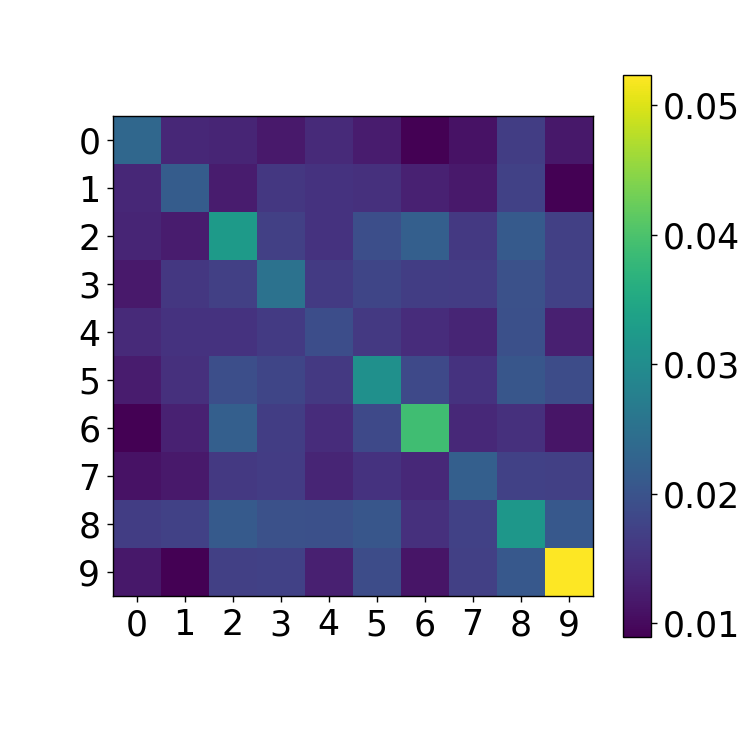

In [20]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
cp = ax.imshow(cov[:10, :10])
fig.colorbar(cp, ax=ax)
ax.set_xticks(np.arange(10))
ax.set_xticklabels(np.arange(10).astype(str))
ax.set_yticks(np.arange(10))
ax.set_yticklabels(np.arange(10).astype(str))
# fig.savefig('')
plt.show()

# Draw the relation between risk expectation `V(n)` and `n`

<IPython.core.display.Javascript object>


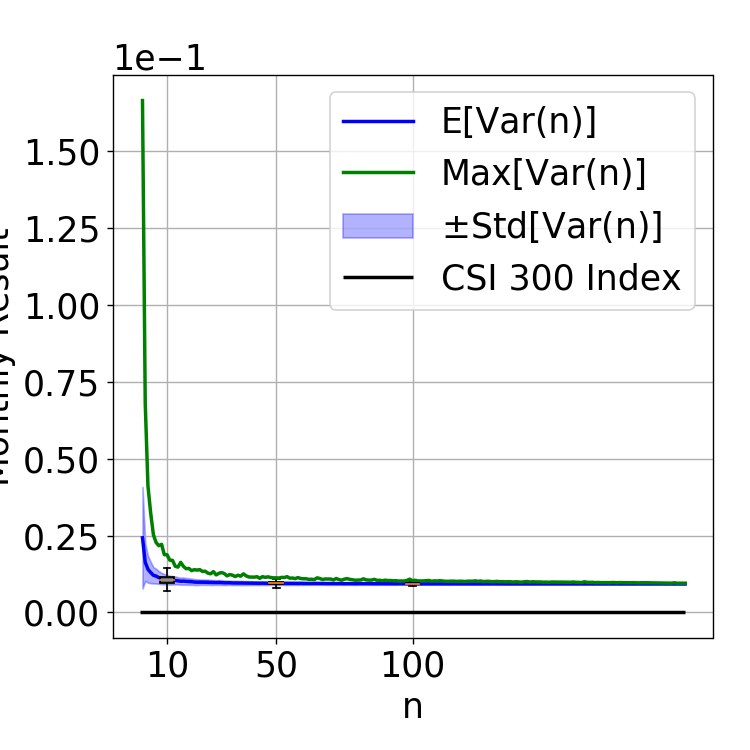

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [21]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
# ax = plt.subplot2grid((1,1),(0,0))
ds = [averVvec(np.full(sampleN, 10)), averVvec(np.full(sampleN, 50)), averVvec(np.full(sampleN, 100))]
for i, ni in enumerate([10, 50, 100]):
    np.savetxt(frequency + str(ni) + '.csv', ds[i], delimiter=',')
ax.boxplot(ds, positions=[10, 50, 100], sym='', patch_artist=True, widths=5)
ax.plot(n, aver, color='b', label='E[Var(n)]')
# ax.plot(n, vmed, color='y', label='Med[Var(n)]')
ax.fill_between(n, aver - vstd, aver + vstd, color='b', alpha=0.3, label=r'$\pm$Std[Var(n)]')
ax.plot(n, vmax, color='g', label='Max[Var(n)]')
ax.hlines(0.000144, 0, n.max(), label='CSI 300 Index')
# ax.plot(n, vmin, color='y', label='Min[Var(n)]')
ax.set_xlabel('n')
ax.set_ylabel(frequency + ' Result')
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1)) 
ax.legend()
# ax.set_yscale('log')
fig.tight_layout()
fig.savefig(frequency + 'risk.png')
# plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


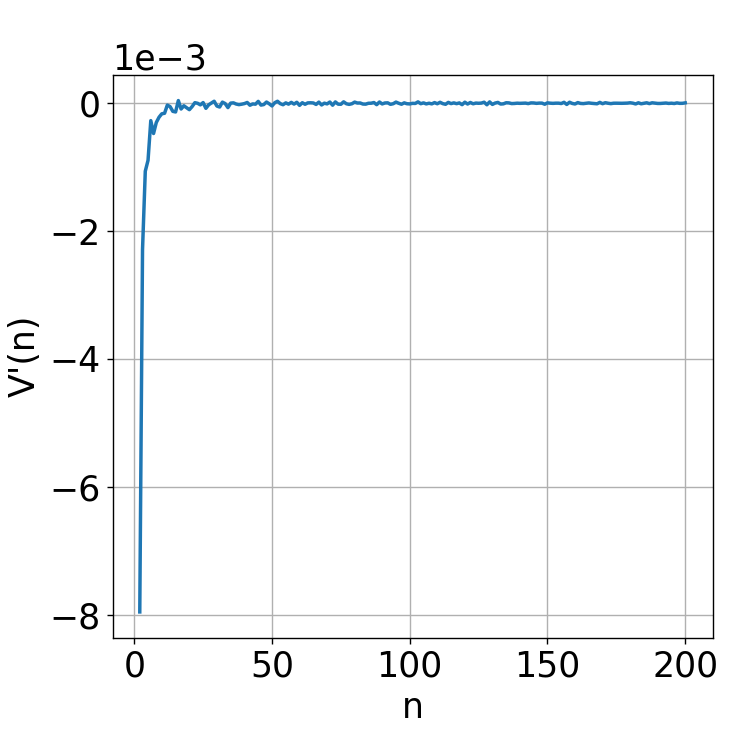

In [22]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
ax.plot(n[1:], np.diff(aver), label="V'(n)")
ax.set_xlabel('n')
ax.set_ylabel("V'(n)")
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1)) 
# ax.legend()
# ax.set_yscale('log')
fig.savefig(frequency + 'Derivative')
plt.show()

In [15]:
var = np.trace(cov)
covv = cov.sum() - var

def V(n, a):
    return (var / N - covv / N  / (N - 1)) / (n ** a) + covv / N  / (N - 1)

# cost function
least_squares = LeastSquares(n, aver, aver / np.sqrt(sampleN), V)

# minimize the cost function and give the starting value of a
m = Minuit(least_squares, a=1, name=('a'))
m.limits['a'] = (0, 2)
m.errordef = 1
# finds minimum of least_squares function
m.migrad()  # run optimiser
# accurately computes uncertainties
# m.hesse() 
m.minos()

fit_info = []
for p, v, e in zip(m.parameters, m.values, m.errors):
    fit_info.append(f'{p} = ${v:.3f} \\pm {e:.3f}$')

<IPython.core.display.Javascript object>


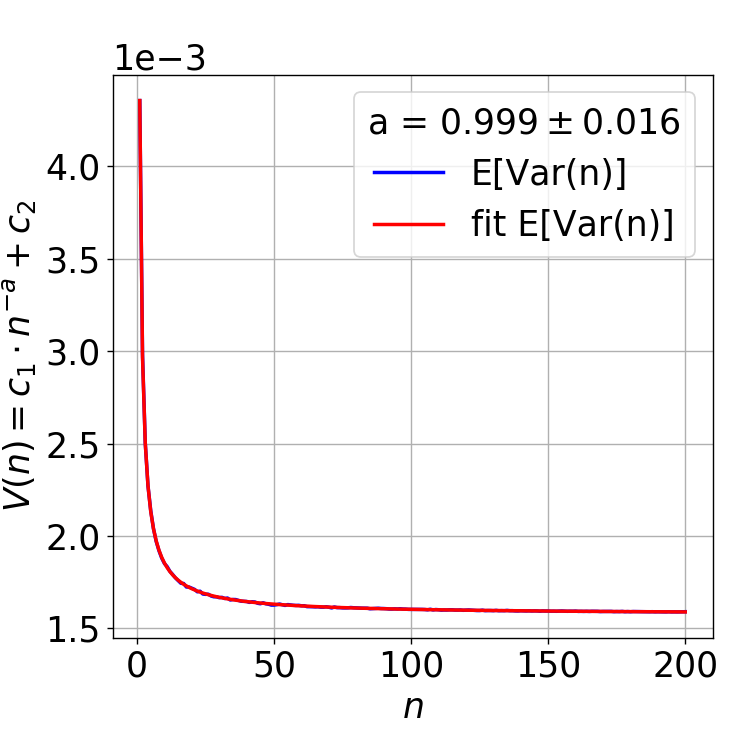

In [16]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
ax.plot(n, aver, color='b', label='E[Var(n)]')
# ax.fill_between(n, aver - vstd, aver + vstd, color='b', alpha=0.3, label=r'$\pm$Std')
# ax.plot(n, vmax, color='g', label='Max[Var(n)]')
ax.plot(n, V(n, *m.values), color='r', label='fit E[Var(n)]')
# ax.hlines(0.000144, 0, n.max(), label='CSI 300 Index')
ax.set_xlabel('$n$')
ax.set_ylabel('$V(n)=c_1 \cdot n^{-a} + c_2$')
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.legend(title='\n'.join(fit_info))
# ax.set_yscale('log')
fig.savefig(frequency + 'fit.png')
plt.show()

<IPython.core.display.Javascript object>


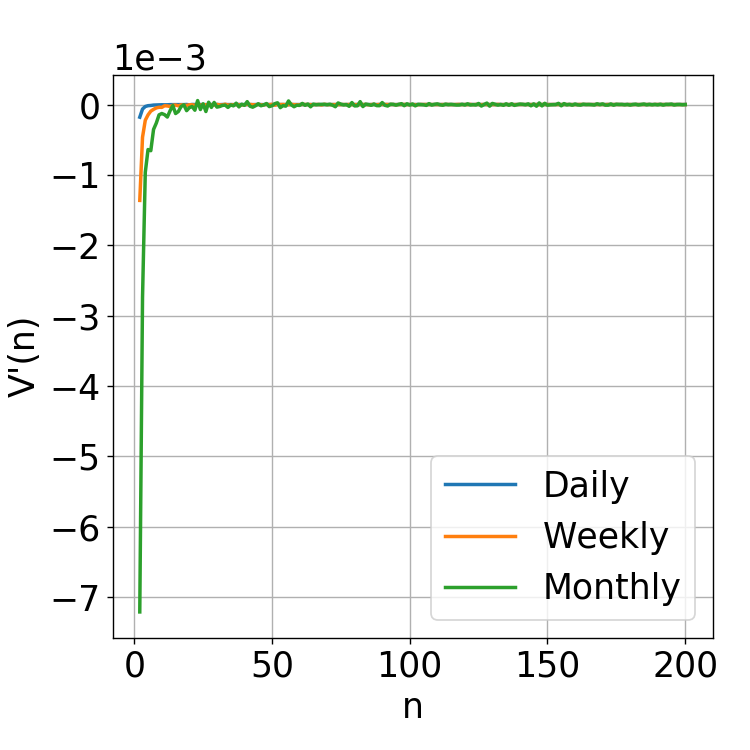

In [7]:
fig = plt.figure(figsize=(6, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.9, bottom=0.15, wspace=0.4, hspace=0.5)
ax = fig.add_subplot(gs[0, 0])
for timespan in ['Daily', 'Weekly', 'Monthly']:
    aver = np.loadtxt(timespan + 'numpydata.csv', delimiter=',')[:, 1]
    ax.plot(n[1:], np.diff(aver), label=timespan)
ax.set_xlabel('n')
ax.set_ylabel("V'(n)")
ax.grid()
ax.yaxis.get_major_formatter().set_powerlimits((0, 1))
ax.legend()
# ax.set_yscale('log')
fig.savefig('Comparation')
plt.show()